In [10]:
# Hyperparameters
n_prev_actions = 9
batch_size = 32

## Data Preparation

In [11]:
import pandas as pd
from preprocess_data import *

import pandas as pd
df = (
    pd.read_csv("df_clean.csv", index_col = 0)
    .assign(action_token = lambda d: pd.Categorical(d.action_token))
)

vocab = df['action_token'].cat.categories

df

,match_id,action_token,dataset
0,315,"True,pass,4,4",train
1,315,"True,receival,4,5",train
2,315,"True,dribble,4,5",train
3,315,"True,pass,5,5",train
4,315,"True,receival,6,4",train
...,...,...,...
939915,82,"False,receival,8,0",test
939916,82,"False,dribble,8,0",test
939917,82,"True,tackle,9,0",test
939918,82,"True,dribble,9,0",test


In [12]:
import numpy as np
import torch

train_df = df.query("dataset == 'train'")
X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (n_prev_actions,))
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train[:-1], X_train[1:, -1])),
    batch_size = batch_size,
    shuffle = True
)

val_df = df.query("dataset == 'val'")
X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (n_prev_actions,))
val_loader = torch.utils.data.DataLoader(
    list(zip(X_val[:-1], X_val[1:, -1])),
    batch_size = batch_size,
    shuffle = True
)

len(train_loader), len(val_loader)

(23382, 2938)

## Training Loop

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def accuracy(preds, labels):
    return sum(preds[:, -1].argmax(dim=1) == labels.argmax(dim=1)) / len(preds)

def train(model, device, n_epochs=20, lr=0.002, save_name="weights"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        model.train()
        i = 0
        train_loss = 0
        train_acc = 0
        for x_bat, y_bat in tqdm(iter(train_loader)):
            x_bat = x_bat.to(device)
            y_bat = y_bat.to(device)

            y_bat = F.one_hot(y_bat, num_classes=len(vocab)).float()
            optimizer.zero_grad()
            y_pred = model(x_bat)
            loss = criterion(y_pred[:, -1, :], y_bat)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            i += 1
            train_acc += accuracy(y_pred, y_bat)

            # print(f'Epoch {epoch}, iter {i}, loss: {loss.item()}')

        train_acc = train_acc / len(train_loader)
        train_loss = train_loss / len(train_loader)
        model.eval()
        val_loss = 0
        val_acc = 0
        for x_val, y_val in tqdm(iter(val_loader)):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(x_val)
            y_val = F.one_hot(y_val, num_classes=len(vocab)).float()
            loss = criterion(y_pred[:, -1, :], y_val)
            val_loss += loss.item()
            val_acc += accuracy(y_pred, y_val)

        val_acc = val_acc / len(val_loader)
        val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch}, iter {i}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        torch.save(model.state_dict(), f'{save_name}_epoch{epoch}.pt')

    return train_losses, train_accs, val_losses, val_accs

In [29]:
from models.transformer import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

model = BasicTransformer(len(vocab), 50, 2, 500, 1, 0.0).to(device=device)

train_losses, train_accs, val_losses, val_accs = train(model, device, save_name='checkpoints/model1')

cuda


100%|██████████| 2938/2938 [00:03<00:00, 912.79it/s]


Epoch 0, iter 23382, train_loss: 2.9983080611717567, train_acc: 0.3835870027542114, val_loss: 2.7759058259635494, val_acc: 0.3973153531551361


100%|██████████| 2938/2938 [00:03<00:00, 907.03it/s]


Epoch 1, iter 23382, train_loss: 2.735341520705487, train_acc: 0.4002780616283417, val_loss: 2.729014208399576, val_acc: 0.4048779010772705


 69%|██████▉   | 16076/23382 [00:38<00:18, 390.58it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

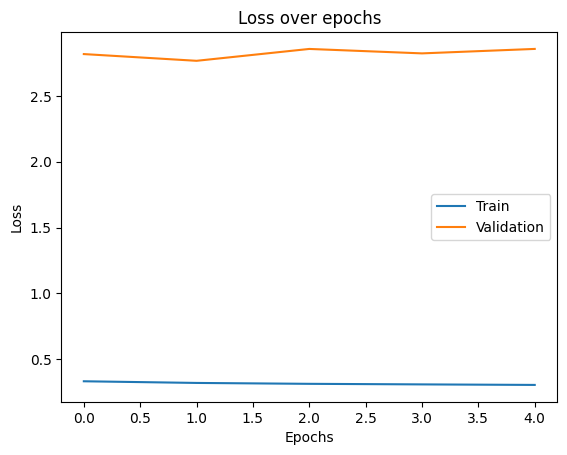

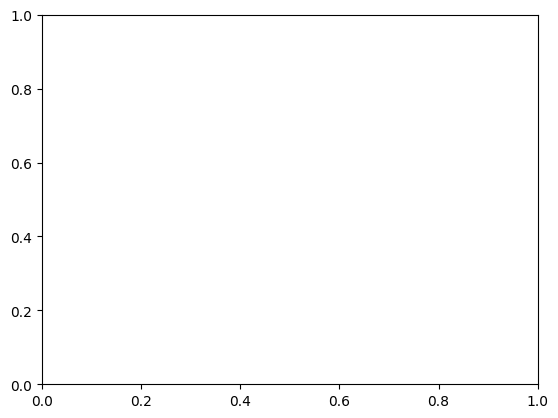

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.savefig("losses.png", bbox_inches="tight")

plt.figure()
plt.plot(train_accs)
plt.plot(val_accs)
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.savefig("accs.png", bbox_inches="tight")

In [21]:
torch.save(model.state_dict(), "transformer_weights.pkl")